In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df = pd.read_csv('/kaggle/input/traffic-collisions-toronto/Traffic_Collisions_Toronto_data.csv')

/kaggle/input/city-of-toronto-neighbourhood-profiles-2016/toronto_neighbourhood_profiles_2016.csv
/kaggle/input/traffic-collisions-toronto/Traffic_Collisions_Toronto_data.csv


**PART 1. CLEANING AND PREPARING THE DATASET**

In [2]:
df.head()

,X,Y,OBJECTID,EventUniqueId,OccurrenceDate,Month,Day_of_Week,Year,Hour,Division,Atom,Neighbourhood,Fatalities,Injury_Collisions,FTR_Collisions,PD_Collisions,Longitude,Latitude,ObjectId2
0,0.0,0.0,1,GO-20141001,2014/02/07 05:00:00+00,February,Friday,2014,16,NSA,NSA,NSA,0,NO,NO,YES,0.0,0.0,1
1,0.0,0.0,2,GO-20141225593,2014/01/02 05:00:00+00,January,Thursday,2014,3,NSA,NSA,NSA,0,NO,YES,NO,0.0,0.0,2
2,0.0,0.0,3,GO-20141260499,2014/01/01 05:00:00+00,January,Wednesday,2014,2,NSA,NSA,NSA,0,YES,NO,NO,0.0,0.0,3
3,0.0,0.0,4,GO-20141260663,2014/01/01 05:00:00+00,January,Wednesday,2014,3,NSA,NSA,NSA,0,NO,NO,YES,0.0,0.0,4
4,0.0,0.0,5,GO-20141261162,2014/01/01 05:00:00+00,January,Wednesday,2014,5,NSA,NSA,NSA,0,YES,NO,NO,0.0,0.0,5


In [3]:
df.dtypes

X                    float64
Y                    float64
OBJECTID               int64
EventUniqueId         object
OccurrenceDate        object
Month                 object
Day_of_Week           object
Year                   int64
Hour                   int64
Division              object
Atom                  object
Neighbourhood         object
Fatalities             int64
Injury_Collisions     object
FTR_Collisions        object
PD_Collisions         object
Longitude            float64
Latitude             float64
ObjectId2              int64
dtype: object

We will have some data that we want to reprocess. From metadata we know that:
1. **OBJECTID** and **ObjectId2** are essentially duplicates, and are index columns. We will drop those, and create a new index
2. **OccurenceDate** -- we will change this to datetime type
3. Once we have **OccurenceDate** as datetime we will see whether we need to keep separately columns for **Month**, **Year**, **Hour**
4. For computational efficiencies we will change to category types columns **Division**, **Atom** and **Neighbourhood** after cleaning them from missing data
5. Columns **Injury_Collisions**, **FTR_Collisions**, **PD_Collisions** should be converted to boolean

In [4]:
df.shape
## Our data has 499 538 observations (and 19 columns)

(499538, 19)

In [5]:
## Let's drop columns we won't use:
df_clean = df.drop(['OBJECTID','ObjectId2'], axis=1)

## We don't have any data explicitely marked as 'NaN', but that could be how our data is marked
print(df_clean.isna().sum())

## Let's convert OccurrenceDate column to datetime. 
df_clean['OccurrenceDate'] = pd.to_datetime(df['OccurrenceDate'], yearfirst=True)

## We will convert Division, Atom and Neighbourhood into categorical variables, but before let's explore them:
print(df_clean['Division'].unique())
print(df_clean['Atom'].unique())

## We can see that we have 'NSA' values:
## We have observations where Neighborhood ID (Atom) is missing, but Police division is present:
print(df_clean[df_clean['Atom']=='NSA'].groupby(['Division']).aggregate({'EventUniqueId':'count'}))

## We also have observations wher Police division is 'NSA', but Neighbourhood ID is present:
print(df_clean[df_clean['Division']=='NSA'].groupby(['Atom']).aggregate({'EventUniqueId':'count'}))

X                    0
Y                    0
EventUniqueId        0
OccurrenceDate       0
Month                0
Day_of_Week          0
Year                 0
Hour                 0
Division             0
Atom                 0
Neighbourhood        0
Fatalities           0
Injury_Collisions    0
FTR_Collisions       0
PD_Collisions        0
Longitude            0
Latitude             0
dtype: int64
['NSA' 'D54/D55' 'D43' 'D41' 'D11' 'D31' 'D32' 'D14' 'D53' 'D12' 'D33'
 'D42' 'D23' 'D22' 'D52' 'D13' 'D51']
['NSA' '40' '531' '25' '27' '31' '48' '119' '76' '134' '117' '128' '14'
 '136' '23' '34' '49' '21' '39' '139' '127' '124' '120' '122' '75' '47'
 '24' '137' '35' '131' '133' '123' '88' '1' '103' '45' '105' '140' '135'
 '132' '138' '129' '130' '125' '126' '121' '63' '62' '61' '118' '54' '43'
 '70' '116' '60' '64' '66' '65' '59' '58' '53' '44' '42' '46' '69' '55'
 '68' '67' '77' '57' '73' '41' '72' '56' '71' '52' '98' '74' '99' '95'
 '78' '104' '51' '79' '97' '50' '82' '100' '96' '101'

In [6]:
## Since this is not a significant portion of observations, and each Division is reponsible for multiple neighborhoods, we will drop all NSA values:
NSA_selector = (df_clean['Division']=='NSA') | (df_clean['Atom']=='NSA') | (df_clean['Neighbourhood']=='NSA')

df_clean = df_clean[~NSA_selector]

## After dropping, we have 426 811 observations (vs 499 538) -- we've dropped 15% of rows
print(df_clean.shape)

(426811, 17)


In [7]:
## Now let's convert to category type: this will improve performace and computational efficiency
df_clean['Division'] = df_clean.Division.astype('category')
df_clean['Atom'] = df_clean.Atom.astype('category')
df_clean['Neighbourhood'] = df_clean.Neighbourhood.astype('category')
print(df_clean.dtypes)

## Now we convert Injury_Collisions, FTR_Collisions, PD_Collisions should be converted to boolean
boolean_columns = ['Injury_Collisions','FTR_Collisions','PD_Collisions']

for i in boolean_columns:
    df_clean[i] = df_clean[i].map({'YES': True, 'NO': False})

X                                float64
Y                                float64
EventUniqueId                     object
OccurrenceDate       datetime64[ns, UTC]
Month                             object
Day_of_Week                       object
Year                               int64
Hour                               int64
Division                        category
Atom                            category
Neighbourhood                   category
Fatalities                         int64
Injury_Collisions                 object
FTR_Collisions                    object
PD_Collisions                     object
Longitude                        float64
Latitude                         float64
dtype: object


In [8]:
print(df_clean.dtypes)

X                                float64
Y                                float64
EventUniqueId                     object
OccurrenceDate       datetime64[ns, UTC]
Month                             object
Day_of_Week                       object
Year                               int64
Hour                               int64
Division                        category
Atom                            category
Neighbourhood                   category
Fatalities                         int64
Injury_Collisions                   bool
FTR_Collisions                      bool
PD_Collisions                       bool
Longitude                        float64
Latitude                         float64
dtype: object


**PART 2. EXPLORING THE CLEAN DATASET**

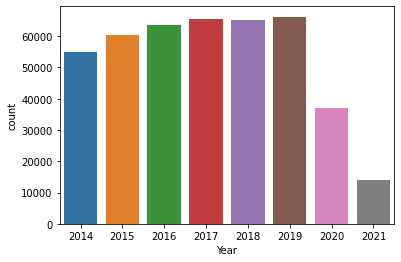

In [9]:
## Let's do some EDA now
import matplotlib.pyplot as plt
import seaborn as sns

# First of all let's try to have a look at overall collisions by year

sns.countplot(x='Year', data=df_clean)
plt.show()
## We can see that collisions by year were growing until 2019 when they rapidly dropped in 2020 and 2021 -- during the COVID pandemics

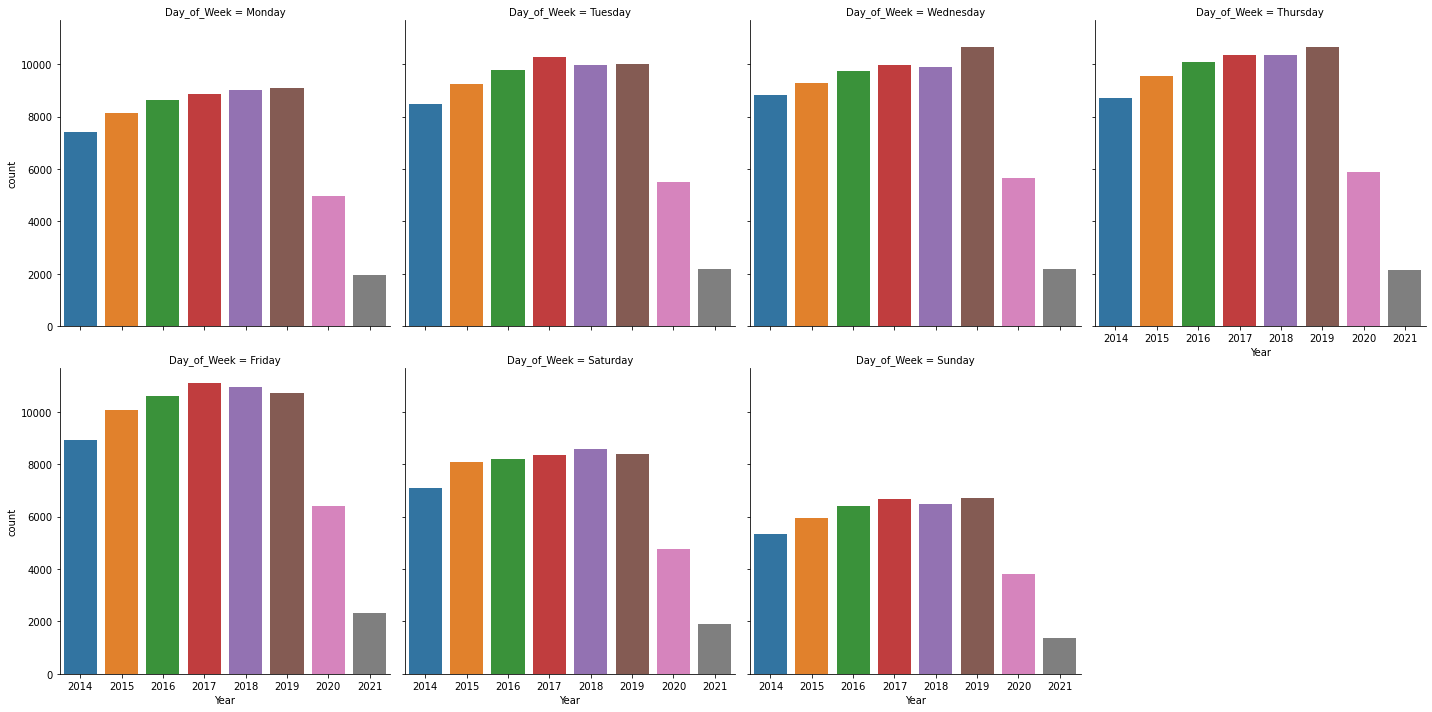

In [10]:
week_list = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.catplot(x='Year', col='Day_of_Week', data=df_clean, kind='count', col_order=week_list, col_wrap=4)
plt.show()

## The trend is the same for all days of the week. Is it the same across all divisions?

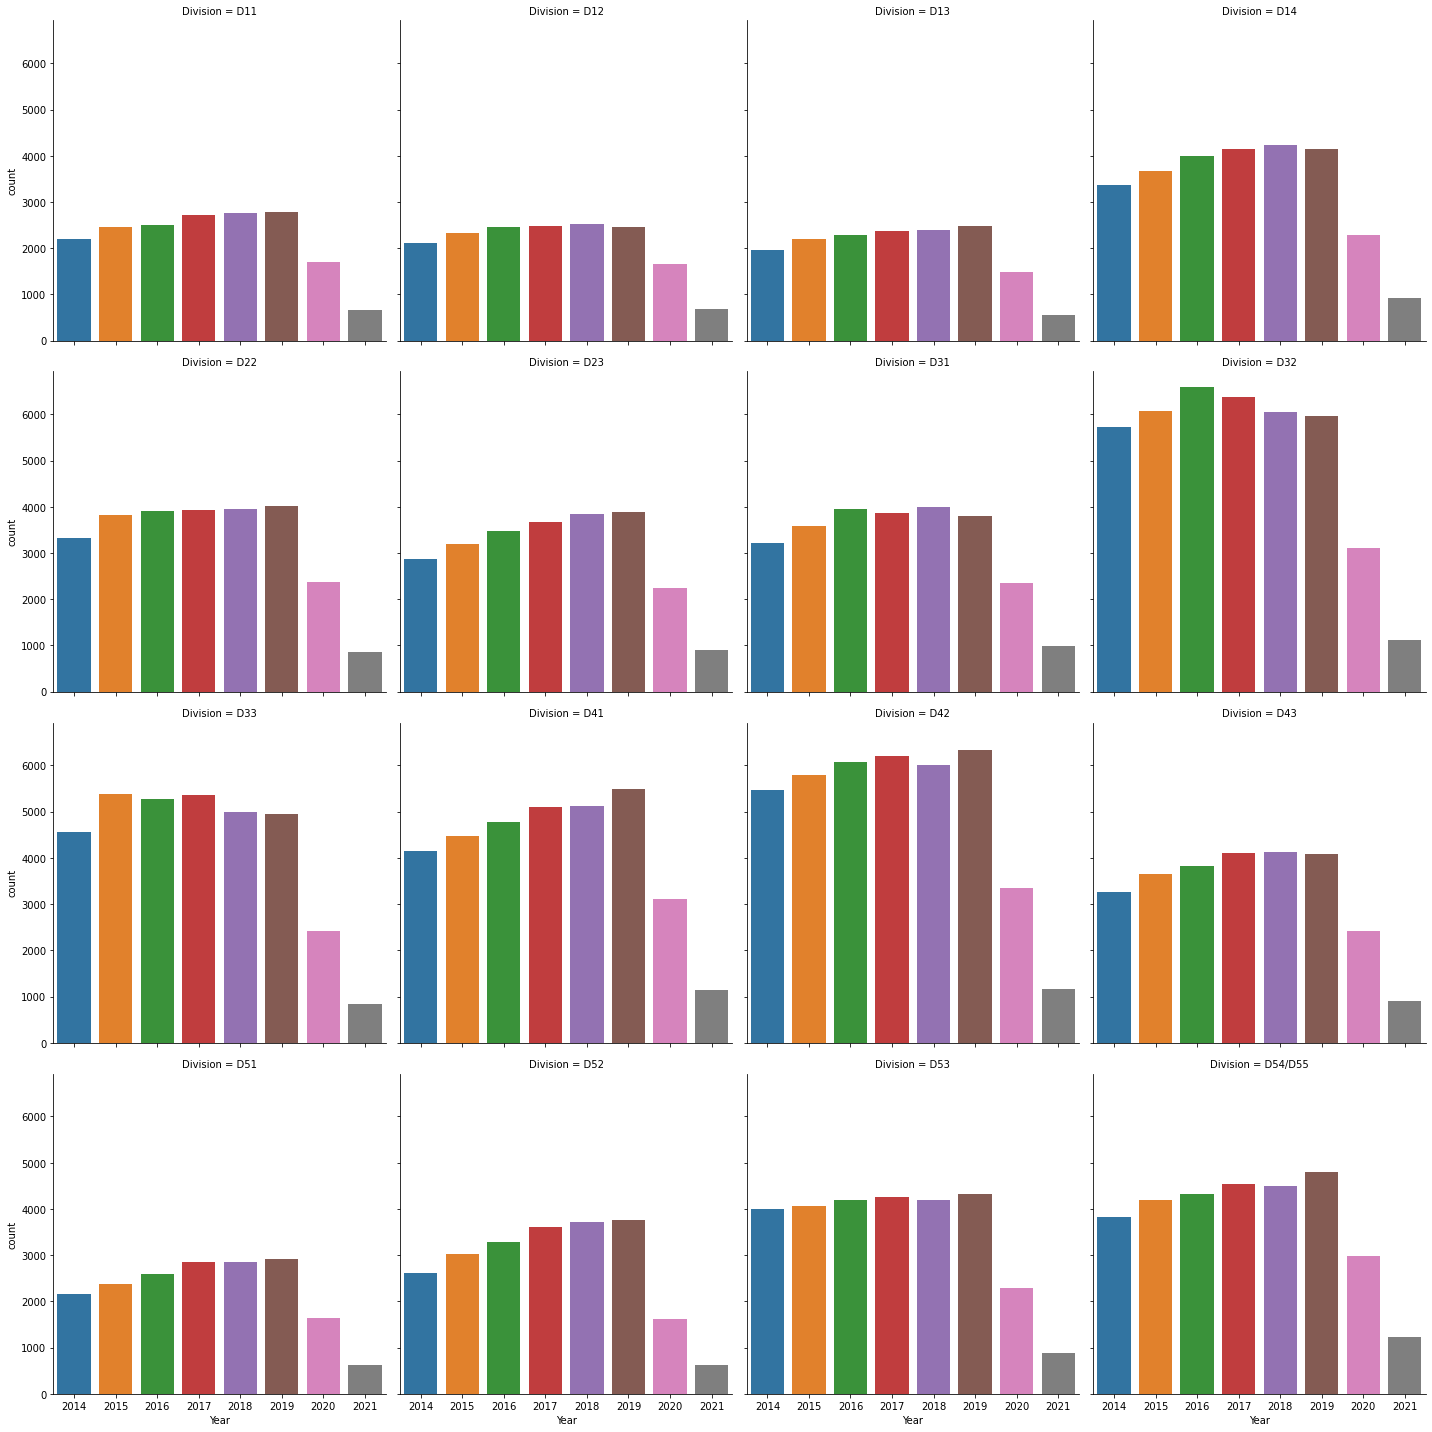

In [11]:
sns.catplot(x='Year', col='Division', data=df_clean, kind='count', col_wrap=4)
plt.show()
## The drop was consistent across all divisions

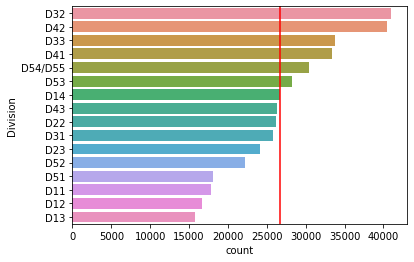

In [12]:
divisions_order = list(df_clean.groupby('Division').aggregate({'EventUniqueId':'count'}).sort_values(by='EventUniqueId', ascending=False).index)
mean_collisions = df_clean.groupby('Division').aggregate({'EventUniqueId':'count'}).sort_values(by='EventUniqueId', ascending=False)['EventUniqueId'].mean()
sns.countplot(y='Division', data=df_clean, order=divisions_order)
plt.axvline(x = mean_collisions, color = 'r', linestyle = '-')
plt.show()

##Divisions 32, 42, 33, 41, 54/55, and 53 had higher than average collisions.
## It would be interesting to look closer at top2 and bottom2 divisions (D32&D42 and D12&D13 and see what is the difference between them)

          EventUniqueId  cum_sum   percent  cum_percent
Division                                               
D32               41016    41016  9.609874     9.609874
D42               40411    81427  9.468125    19.077999
D33               33772   115199  7.912636    26.990635
D41               33383   148582  7.821495    34.812130
D54/D55           30396   178978  7.121653    41.933783
D53               28178   207156  6.601985    48.535769
D14               26751   233907  6.267645    54.803414
D43               26373   260280  6.179082    60.982496
D22               26207   286487  6.140189    67.122684
D31               25735   312222  6.029601    73.152285
D23               24082   336304  5.642310    78.794595
D52               22252   358556  5.213549    84.008144
D51               18036   376592  4.225758    88.233902
D11               17787   394379  4.167418    92.401320
D12               16689   411068  3.910162    96.311482
D13               15743   426811  3.688518   100

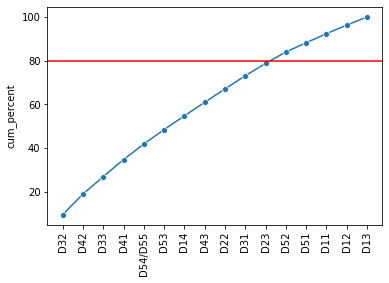

In [13]:
divisions = df_clean.groupby('Division').aggregate({'EventUniqueId':'count'}).sort_values(by='EventUniqueId', ascending=False)
divisions['cum_sum'] = divisions['EventUniqueId'].cumsum()
divisions['percent'] = 100*(divisions['EventUniqueId']/divisions['cum_sum'].max())
divisions['cum_percent'] = 100*(divisions['cum_sum']/divisions['cum_sum'].max())
print(divisions)

x_div = list(divisions.index)
sns.lineplot(x=x_div, y=divisions['cum_percent'],marker='o')
plt.axhline(y = 80, color = 'r', linestyle = '-')
plt.xticks(rotation=90)
plt.show()

Traffic collisions are mostly evenly distributed among divisions, even though D32 and D42 have more collisions that average

In [14]:
#print(df_clean[df_clean['Division']=='D32'].groupby(['Neighbourhood']).aggregate({'EventUniqueId':'count'}).sort_values(by='EventUniqueId', ascending=False))
#print(df_clean[df_clean['Division']=='D13'].groupby(['Neighbourhood']).aggregate({'EventUniqueId':'count'}).sort_values(by='EventUniqueId', ascending=False))
x = df_clean[df_clean['Division']=='D42'].groupby(['Neighbourhood']).aggregate({'EventUniqueId':'count'}).sort_values(by='EventUniqueId', ascending=False)
x[x['EventUniqueId']>0]

,EventUniqueId
Neighbourhood,
Milliken (130),7692
Agincourt South-Malvern West (128),6103
Rouge (131),5902
Malvern (132),5317
LAmoreaux (117),4427
Tam OShanter-Sullivan (118),3789
Agincourt North (129),3608
Steeles (116),3380
Centennial Scarborough (133),191


It would be interested to compare data on neighborhood vs population of each neighborhood, but we don't have this data in the dataset, so we will load the dataset from Toronto portal

In [15]:
df_pop = pd.read_csv('/kaggle/input/city-of-toronto-neighbourhood-profiles-2016/toronto_neighbourhood_profiles_2016.csv')
df_pop

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2378,2379,Mobility,Mobility status - Place of residence 5 years ago,Census Profile 98-316-X2016001,Movers,"1,040,015","8,610","8,775","3,130","14,735",...,"8,070","7,020","19,235","3,920","2,710","4,700","5,450","6,195","11,400","4,290"
2379,2380,Mobility,Mobility status - Place of residence 5 years ago,Census Profile 98-316-X2016001,Non-migrants,"639,060","5,445","5,610","2,200","8,340",...,"4,305","4,740","11,975","2,920","2,100","3,355","3,020","3,895","6,435","2,940"
2380,2381,Mobility,Mobility status - Place of residence 5 years ago,Census Profile 98-316-X2016001,Migrants,"400,950","3,170","3,145",925,"6,390",...,"3,765","2,270","7,260",985,620,"1,350","2,425","2,310","4,965","1,345"
2381,2382,Mobility,Mobility status - Place of residence 5 years ago,Census Profile 98-316-X2016001,Interprovincial migrants,"42,985",135,220,70,"1,310",...,475,150,335,250,85,210,290,325,195,135


In [16]:
hoods = df_clean['Neighbourhood'].unique()
df_pop[df_pop['Characteristic']=='Neighbourhood Number']

list_hoods = df_pop[df_pop['Characteristic']=='Neighbourhood Number'].iloc[0,6:]

hoods_pop = df_pop[df_pop['Characteristic']=='Population, 2016'].iloc[0,6:]

pop_dict={}

for i in range(len(hoods_pop)):
    for j in range(len(hoods)):
        if hoods_pop.keys()[i] in hoods[j]:
            pop_dict[hoods[j]]=int(hoods_pop[i].replace(',',''))
                   
# List of years = 2014, 2016, 2017, 2018, 2019, 2020, 2021, 2015

collisions_2014 = dict(df_clean[df_clean['Year']==2014].groupby('Neighbourhood').aggregate({'EventUniqueId':'count'})['EventUniqueId'])
#df_clean.groupby('Neighbourhood').count()

In [17]:
#dict(collisions_2014['EventUniqueId'])

# missing hoods in pop_dict?
missing = []
count=0

for key in collisions_2014.keys():
    if key not in pop_dict.keys():
        missing.append(key)
    else:
        count +=1
        
print(missing)
print(count)


[]
140


Traffic collisions by year were growing 2014-2019 until they rapidly dropped in 2020 and 2021 -- all during COVID pandemics